Sharing my understanding of the problem


For this analysis I am assuming the following based on the problem description shared :

Journey of a Lead : ![Insert Image]()

- Bad Outputs : Non-contactable | Invalid Profile | Did Not Qualify
- Positive Outputs : EP Sent --> EP Recieved --> EP Confirmed in that order.
- Best outcome : Lead Closed
- Neutral outcome : Unknown  




1. Leeds


Process of Acquiring Leed

Ad

### Q1. Are we seeing any lead quality trends over time (improving, declining)? Are they statistically significant?


There can be multiple ways of defining lead quality depending on the business objectve. Sharing some ideas below :  

1. Maximizing Closed Leads or Minimizing Bad Leads
    This does take into account the total leads. For example : your closed lead count may continue to stay constant while leads geneated continue to grow. This may be a sign of declining lead quality.
2. Maximizing Avg. Closed Lead Rate or Minimizing Avg. Bad Leads
 : This will take into account the volumetric fluctuations in incoming lead count, and will give us a better understanding of percentage of our leads close or go bad.


3. Weighted Average : More complex quality funtions might involve a weighted formula for all outcomes based on their desirability. I will assign weights manually here but we can determine a more accurate set of weignts with some analysis.
 closed lead : 5, ep s/r/c : 2, neutral : 0, bad -1.








In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
df = pd.read_csv('/Users/vardasinghal/Documents/Analyst case study dataset 1.csv')

In [125]:
df.head()

,LeadCreated,FirstName,Email,VendorLeadID,CallStatus,WidgetName,PublisherZoneName,PublisherCampaignName,AddressScore,PhoneScore,...,Partner,ReferralDomain,MarketingCampaign,AdGroup,Keyword,SearchQuery,ReferralURL,ReferralURL Parameters,LandingPageURL,Landing Page URL Parameters
0,7/1/09,Dorinda,kanani@sandwichisles.net,FDF81FDA-A649-437B-B99C-FDDE74F7971B,NaN,w-302252-DebtReduction1-1DC-CreditSolutions,TopLeft-302252,DebtReductionInc,NaN,5.0,...,google,www.google.com,Debt Holding Tank,Holding Tank - Debt,Debt specialists,debt specialists,http://www.google.com/search,sourceid=navclient&aq=1&oq=debt sp&ie=UTF-8&rl...,http://www.debtreductioninc.com/index8.html,utm_source=google&utm_medium=CPC&utm_content=H...
1,4/13/09,Presetta,clerk2@ustconline.net,4190ACB7-5026-416C-B987-ED8AD427D5E6,NaN,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,AdKnowledge,NaN,Financial Services,Consolidate,NaN,NaN,NaN,NaN,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...
2,4/21/09,Gina,wagoner_gina@yahoo.com,hFg80jf_R0CRN55hdhWILw,Unable to contact - Bad Contact Information,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,AdKnowledge,us.mc582.mail.yahoo.com,Financial Services,Consolidate,NaN,NaN,http://us.mc582.mail.yahoo.com/mc/showMessage,&fid=Inbox&sort=date&order=down&startMid=0&.ra...,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...
3,8/3/09,Kari,usa4ley@yahoo.com,jB01QgYZxkWArI9jWxuufw,Contacted - Doesn't Qualify,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,5.0,3.0,...,Google,norwich.kijiji.com,DebtReductionInc,Lower Payments,NaN,NaN,http://norwich.kijiji.com/c-Cars-vehicles-Cars...,NaN,http://www.debtreductioninc.com/index12.html,utm_source=Google&utm_medium=cpc&utm_campaign=...
4,4/13/09,Stephanie,sr1lambert@embarqmail.com,D5B32074-458E-40EC-B185-1FEF20AC626D,NaN,w-300250-DebtReduction1-1DC-BlueMeter,TopLeft-302252,DebtReductionInc,NaN,NaN,...,Google,NaN,DebtReductionInc,Debt Reduction,NaN,NaN,NaN,NaN,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...


# Data Preparation #

In [116]:
df = df.dropna(how='all')


# Extract Date and Week from Lead_Created
df['Date'] = pd.to_datetime(df['LeadCreated']).dt.date
df['Week'] = pd.to_datetime(df['LeadCreated']).dt.isocalendar().week
df['Month'] = pd.to_datetime(df['LeadCreated']).dt.month

# Translate CallStatus to 4 Enum Categories
def translate_call_status(status):
    if status == 'Closed':
        return 'Closed leads'
    elif status in ['EP Confirmed', 'EP Sent', 'EP Received']:
        return 'Good leads'
    elif status in ['Unable to contact - Bad Contact Information', 'Contacted - Invalid Profile', "Contacted - Doesn't Qualify"]:
        return 'Bad leads'
    else:
        return 'Neutral leads'

df['CallStatusEnum'] = df['CallStatus'].apply(translate_call_status)

# Extract Information like dimention, form format, fieldSet and design name from WidgetName
def extract_widget_details(widget_name):
    try:
        parts = widget_name.split('-')
        # Extract dimension, removing the "w-" prefix
        ad_size = parts[1][0:3] +'x'+ parts[1][3:]
        field_set = parts[2]
        form_type = parts[3]
        design_name = '-'.join(parts[3:])
        return ad_size, field_set, form_type, design_name
    except (IndexError, AttributeError):  # Handle cases where the string is not in the expected format
        return None, None, None, None

df[['AdSize', 'FieldSet', 'FormType', 'DesignName']] = df['WidgetName'].apply(
    lambda x: pd.Series(extract_widget_details(x))
)

# Lower casing fields like Partner, ReferralDomain, Keyword, Search Query and LandingPageURL etc to avoid any errors while grouping
df['Email'] = df['Email'].str.lower()
df['Partner'] = df['Partner'].str.lower()
df['ReferralDomain'] = df['ReferralDomain'].str.lower()
df['MarketingCampaign'] = df['MarketingCampaign'].str.lower()
df['AdGroup'] = df['AdGroup'].str.lower()
df['Keyword'] = df['Keyword'].str.lower()
df['SearchQuery'] = df['SearchQuery'].str.lower()
df['ReferralURL'] = df['ReferralURL'].str.lower()
df['LandingPageURL'] = df['LandingPageURL'].str.lower()

def get_quality_breakdown(df, col_name):
  grouped_df = df.groupby([col_name, 'CallStatusEnum']).size().unstack(fill_value=0)
  grouped_df['Total leads'] = grouped_df.sum(axis=1)

  for col in ['Closed leads', 'Good leads', 'Bad leads', 'Neutral leads']:
    grouped_df[f'{col} %'] = (grouped_df[col] / grouped_df['Total leads']) * 100
  
  grouped_df['Weighted Quality Score'] = (5 * grouped_df['Closed leads %'] + 
                                        2 * grouped_df['Good leads %'] +
                                        0 * grouped_df['Neutral leads %'] +
                                        (-1) * grouped_df['Bad leads %']) / 100
  return grouped_df


def get_line_plot(df, x, y, title, marker, color):
  plt.figure(figsize=(6, 4))
  plt.plot(df.index, df[y], marker=marker, color=color, label=y)
  # Adding labels and title
  plt.title(title, fontsize=16)
  plt.xlabel(x, fontsize=12)
  plt.ylabel(y, fontsize=12)
  # Rotate x-axis labels for better readability
  plt.xticks(rotation=45)
  # Add grid for better readability
  plt.grid(True)
  # Show the plot
  plt.legend()
  plt.tight_layout()
  plt.show()


def get_histogram(df, x, y, title):
  df_sorted = df.sort_values(by=y, ascending=False)
  df_sorted.plot(kind='bar', y=y, figsize=(10, 6))
  plt.title(title)
  plt.xlabel(x)
  plt.ylabel(y)
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()



def get_multi_line_plot(df, x, y, label, title, ):
    plt.figure(figsize=(6, 4))
    for i in df[label].unique():
      i_data = df[df[label] == i]
      i_breakdown = get_quality_breakdown(i_data, x)
      plt.plot(i_breakdown.index, i_breakdown[y], label=i)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



def get_agg_breakdown(df):
  total_leads = len(df)
  bad_leads = len(df[df['CallStatusEnum'] == 'Bad leads'])
  good_leads = len(df[df['CallStatusEnum'] == 'Good leads'])
  neutral_leads = len(df[df['CallStatusEnum'] == 'Neutral leads'])
  closed_leads = len(df[df['CallStatusEnum'] == 'Closed leads'])

  closed_leads_percentage = (closed_leads / total_leads) * 100 if total_leads > 0 else 0
  bad_leads_percentage = (bad_leads / total_leads) * 100 if total_leads > 0 else 0

  weighted_score = (5 * ( closed_leads / total_leads) +
                    2 * (good_leads / total_leads) +
                    0 * ( neutral_leads / total_leads) -
                    1 * (bad_leads / total_leads)) if total_leads > 0 else 0


  # Create a new DataFrame with the summary
  summary_df = pd.DataFrame({
    'Total Leads': [total_leads],
    'Bad leads': [bad_leads],
    'Good leads': [good_leads],
    'Neutral leads': [neutral_leads],
    'Closed leads': [closed_leads],
    'Closed leads %': [closed_leads_percentage],
    'Bad leads %': [bad_leads_percentage],
    'Weighted Quality Score': [weighted_score]
  })

  return summary_df
    


# Display the updated DataFrame
df.head()

/var/folders/r2/6pymwb3s4536v40rq_kbtp4r0000gn/T/ipykernel_15450/3576230040.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['LeadCreated']).dt.date
/var/folders/r2/6pymwb3s4536v40rq_kbtp4r0000gn/T/ipykernel_15450/3576230040.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Week'] = pd.to_datetime(df['LeadCreated']).dt.isocalendar().week
/var/folders/r2/6pymwb3s4536v40rq_kbtp4r0000gn/T/ipykernel_15450/3576230040.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Month'] = pd.to_datetime(df['LeadCreated']).dt.month


,LeadCreated,FirstName,Email,VendorLeadID,CallStatus,WidgetName,PublisherZoneName,PublisherCampaignName,AddressScore,PhoneScore,...,LandingPageURL,Landing Page URL Parameters,Date,Week,Month,CallStatusEnum,AdSize,FieldSet,FormType,DesignName
0,7/1/09,Dorinda,kanani@sandwichisles.net,FDF81FDA-A649-437B-B99C-FDDE74F7971B,NaN,w-302252-DebtReduction1-1DC-CreditSolutions,TopLeft-302252,DebtReductionInc,NaN,5.0,...,http://www.debtreductioninc.com/index8.html,utm_source=google&utm_medium=CPC&utm_content=H...,2009-07-01,27,7,Neutral leads,302x252,DebtReduction1,1DC,1DC-CreditSolutions
1,4/13/09,Presetta,clerk2@ustconline.net,4190ACB7-5026-416C-B987-ED8AD427D5E6,NaN,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...,2009-04-13,16,4,Neutral leads,300x250,DebtReduction1,1DC,1DC-Head2
2,4/21/09,Gina,wagoner_gina@yahoo.com,hFg80jf_R0CRN55hdhWILw,Unable to contact - Bad Contact Information,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...,2009-04-21,17,4,Bad leads,300x250,DebtReduction1,1DC,1DC-Head2
3,8/3/09,Kari,usa4ley@yahoo.com,jB01QgYZxkWArI9jWxuufw,Contacted - Doesn't Qualify,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,5.0,3.0,...,http://www.debtreductioninc.com/index12.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,2009-08-03,32,8,Bad leads,302x252,DebtReduction1,1DC,1DC-white
4,4/13/09,Stephanie,sr1lambert@embarqmail.com,D5B32074-458E-40EC-B185-1FEF20AC626D,NaN,w-300250-DebtReduction1-1DC-BlueMeter,TopLeft-302252,DebtReductionInc,NaN,NaN,...,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,2009-04-13,16,4,Neutral leads,300x250,DebtReduction1,1DC,1DC-BlueMeter


In [117]:
get_agg_breakdown(df)

,Total Leads,Bad leads,Good leads,Neutral leads,Closed leads,Closed leads %,Bad leads %,Weighted Quality Score
0,3021,488,148,2140,245,8.109897,16.153592,0.34194


In [113]:
total_rows = df.shape[0]
total_rows

2747

In [5]:
wow_breakdown_df = get_quality_breakdown(df, 'Week')
wow_breakdown_df


CallStatusEnum,Bad leads,Closed leads,Good leads,Neutral leads,Total leads,Closed leads %,Good leads %,Bad leads %,Neutral leads %,Weighted Quality Score
Week,,,,,,,,,,
14,3,3,3,28,37,8.108108,8.108108,8.108108,75.675676,0.486486
15,9,15,3,92,119,12.605042,2.521008,7.563025,77.310924,0.605042
16,10,16,5,94,125,12.800000,4.000000,8.000000,75.200000,0.640000
17,22,14,11,108,155,9.032258,7.096774,14.193548,69.677419,0.451613
18,14,10,4,101,129,7.751938,3.100775,10.852713,78.294574,0.341085
19,10,10,3,90,113,8.849558,2.654867,8.849558,79.646018,0.407080
20,20,12,9,125,166,7.228916,5.421687,12.048193,75.301205,0.349398
21,11,8,3,100,122,6.557377,2.459016,9.016393,81.967213,0.286885
22,15,5,4,108,132,3.787879,3.030303,11.363636,81.818182,0.136364


### Added a weighted Quality score ###


# Lead Quality Trends #

*Note : I am looking at the analysis at a weekly level as monthly data is limited to just 6 points and the daily data is too sparse*

### Total Lead Count over Time



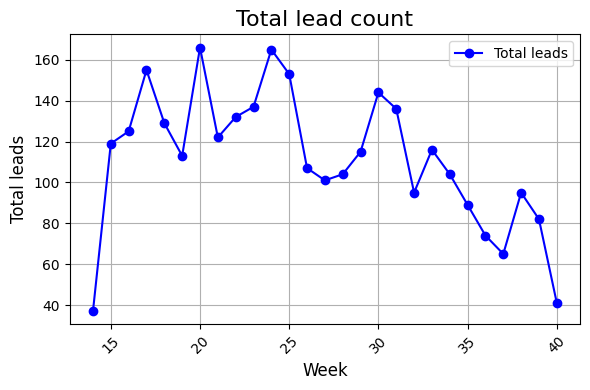

In [80]:
get_line_plot(wow_breakdown_df, 'Week', 'Total leads', 'Total lead count', marker='o', color='b')

The no of incoming leads are declining over time.

### Closed Lead count over time

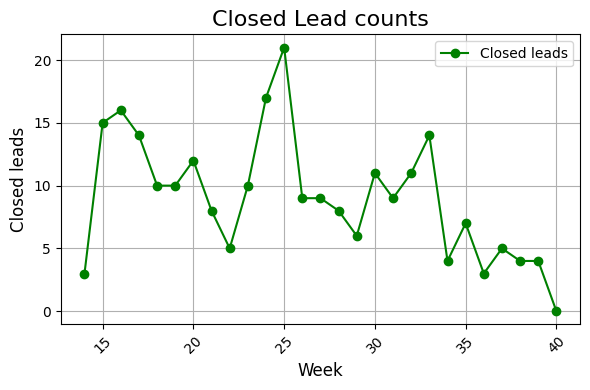

In [82]:
get_line_plot(wow_breakdown_df, 'Week', 'Closed leads', 'Closed Lead counts', marker='o', color='g')

### Bad Lead Count over time

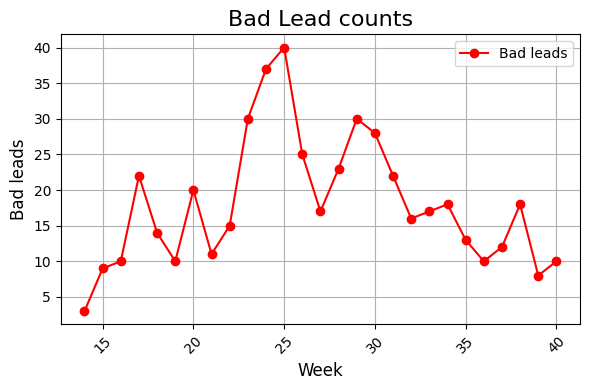

In [119]:
get_line_plot(wow_breakdown_df, 'Week', 'Bad leads', 'Bad Lead counts', marker='o', color='r')

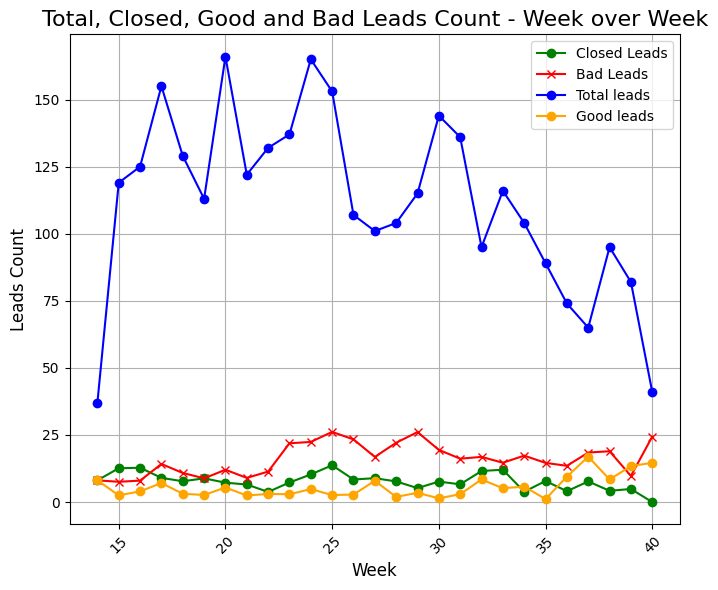

In [32]:
import matplotlib.pyplot as plt

# Set up the figure and axis for the plot
plt.figure(figsize=(7, 6))

# Plot the closed lead counts
plt.plot(wow_breakdown_df.index, wow_breakdown_df['Closed leads %'], marker='o', color='g', label='Closed Leads')

# Plot the bad lead counts on the same axis
plt.plot(wow_breakdown_df.index, wow_breakdown_df['Bad leads %'], marker='x', color='r', label='Bad Leads')

# Plot the bad lead counts on the same axis
plt.plot(wow_breakdown_df.index, wow_breakdown_df['Total leads'], marker='o', color='b', label='Total leads')

# Plot the bad lead counts on the same axis
plt.plot(wow_breakdown_df.index, wow_breakdown_df['Good leads %'], marker='o', color='orange', label='Good leads')

# Adding labels and title
plt.title('Total, Closed, Good and Bad Leads Count - Week over Week', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Leads Count', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid to the plot
plt.grid(True)

# Add legends to differentiate the two lines
plt.legend(loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()



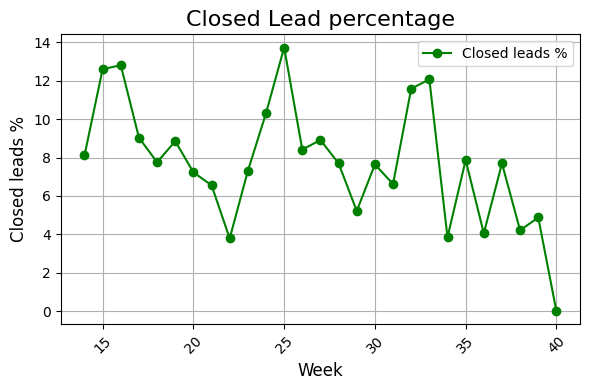

In [84]:
get_line_plot(wow_breakdown_df, 'Week', 'Closed leads %', 'Closed Leads percentage', marker='o', color='g')

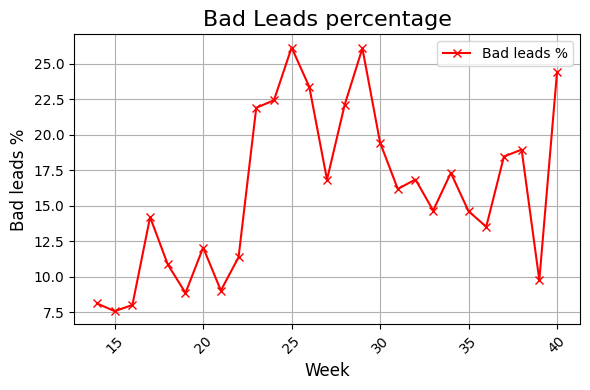

In [86]:
get_line_plot(wow_breakdown_df, 'Week', 'Bad leads %', 'Bad Leads percentage', marker='x', color='r')

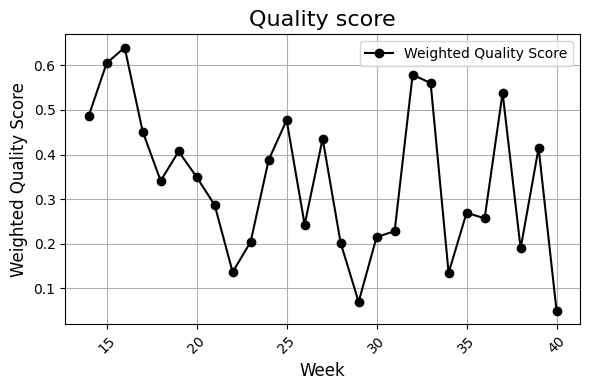

In [88]:
get_line_plot(wow_breakdown_df, 'Week', 'Weighted Quality Score', 'Quality score', marker='o', color='black')

# Statistical Significance #


I am using linear regression as it will quantify the relationship between weeks and Quality score/Closed leads/Bad leads

Independant variable - Weeks

Dependant variable - Quality score/Closed leads/Bad leads

### Closed Leads ###
We have observed that the average closed lead percentage is declining with time . Now we want statistically confirm whether this decline is significant.

Hypothesis Null Hypothesis (Ho): There is no linear relationship between time and the average closed lead percentage

Alternative Hypothesis (H1): There is a linear relationship, and the quality score is changing over time

In [60]:
pip install statsmodels


  Obtaining dependency information for statsmodels from https://files.pythonhosted.org/packages/67/d8/ac30cf4cf97adaa48548be57e7cf02e894f31b45fd55bf9213358d9781c9/statsmodels-0.14.4-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for patsy>=0.5.6 from https://files.pythonhosted.org/packages/87/2b/b50d3d08ea0fc419c183a84210571eba005328efa62b6b98bc28e9ead32a/patsy-1.0.1-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 19.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [69]:
import numpy as np
import statsmodels.api as sm

# Prepare the data: Week number as a numerical variable (if it's not already numeric)
wow_breakdown_df['Week'] = np.arange(len(wow_breakdown_df))

# Independent variable (X) is the Week number, Dependent variable (y) is the Quality Score
X = wow_breakdown_df['Week'].values.reshape(-1, 1)  # Reshaping for regression
y = wow_breakdown_df['Closed leads %'].values

# Add constant to the independent variable for the intercept (required for statsmodels)
X_with_intercept = sm.add_constant(X)  # Adds a constant (intercept) term

# Fit the linear regression model using Ordinary Least Squares (OLS)
model = sm.OLS(y, X_with_intercept)  # OLS regression
results = model.fit()  # Fit the model

# Print the summary to check the p-value, coefficients, and other statistics
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     8.213
Date:                Wed, 29 Jan 2025   Prob (F-statistic):            0.00831
Time:                        22:37:13   Log-Likelihood:                -65.280
No. Observations:                  27   AIC:                             134.6
Df Residuals:                      25   BIC:                             137.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.3282      1.057      9.775      0.0

# Based on the above results, we can say that given **p-value of 0.008**, I can conclude with 95% confidence that the relationship between week and avg closed lead % is statistically significant, suggesting a decline in the avg closed lead % over time #



### Bad Leads ###

We have observed that the average bad lead % is increasing with time . Now we want statistically confirm whether this upward trend is significant.

Hypothesis Null Hypothesis (Ho): There is no linear relationship between time and the average bad lead %

Alternative Hypothesis (H1): There is a linear relationship, and the average bad lead % is changing over time

In [70]:
import numpy as np
import statsmodels.api as sm

# Prepare the data: Week number as a numerical variable (if it's not already numeric)
wow_breakdown_df['Week'] = np.arange(len(wow_breakdown_df))

# Independent variable (X) is the Week number, Dependent variable (y) is the Quality Score
X = wow_breakdown_df['Week'].values.reshape(-1, 1)  # Reshaping for regression
y = wow_breakdown_df['Bad leads %'].values

# Add constant to the independent variable for the intercept (required for statsmodels)
X_with_intercept = sm.add_constant(X)  # Adds a constant (intercept) term

# Fit the linear regression model using Ordinary Least Squares (OLS)
model = sm.OLS(y, X_with_intercept)  # OLS regression
results = model.fit()  # Fit the model

# Print the summary to check the p-value, coefficients, and other statistics
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     6.172
Date:                Wed, 29 Jan 2025   Prob (F-statistic):             0.0200
Time:                        22:37:16   Log-Likelihood:                -82.453
No. Observations:                  27   AIC:                             168.9
Df Residuals:                      25   BIC:                             171.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7821      1.996      5.903      0.0

# Based on the above results, given the **p-value of 0.020**, we can conclude with 95% confidence that there is a statistically significant relationship between week and average bad lead percentage suggesting an increase in avg bad % #


### Weighted Quality Score ###
We have observed that the weighted quality score is declining with time . Now we want statistically confirm whether this decline is significant.


Hypothesis
Null Hypothesis (Ho): There is no linear relationship between time and the quality score

Alternative Hypothesis (H1): There is a linear relationship, and the quality score is changing over time

In [71]:
import numpy as np
import statsmodels.api as sm

# Prepare the data: Week number as a numerical variable (if it's not already numeric)
wow_breakdown_df['Week'] = np.arange(len(wow_breakdown_df))

# Independent variable (X) is the Week number, Dependent variable (y) is the Quality Score
X = wow_breakdown_df['Week'].values.reshape(-1, 1)  # Reshaping for regression
y = wow_breakdown_df['Weighted Quality Score'].values

# Add constant to the independent variable for the intercept (required for statsmodels)
X_with_intercept = sm.add_constant(X)  # Adds a constant (intercept) term

# Fit the linear regression model using Ordinary Least Squares (OLS)
model = sm.OLS(y, X_with_intercept)  # OLS regression
results = model.fit()  # Fit the model

# Print the summary to check the p-value, coefficients, and other statistics
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     3.983
Date:                Wed, 29 Jan 2025   Prob (F-statistic):             0.0570
Time:                        22:37:32   Log-Likelihood:                 12.362
No. Observations:                  27   AIC:                            -20.72
Df Residuals:                      25   BIC:                            -18.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4412      0.060      7.406      0.0

# Based on the above results, we can say that given **p-value of 0.034**, I can conclude with 90% confidence that the relationship between week and quality score is statistically significant, suggesting a decline in the quality score over time #

## What type of person filled the ad ##

In [34]:
statewise_breakdown_df = get_quality_breakdown(df, 'State')
statewise_breakdown_df

CallStatusEnum,Bad leads,Closed leads,Good leads,Neutral leads,Total leads,Closed leads %,Good leads %,Bad leads %,Neutral leads %,Weighted Quality Score
State,,,,,,,,,,
AK,0,1,0,7,8,12.500000,0.000000,0.000000,87.500000,0.625000
AL,15,12,4,65,96,12.500000,4.166667,15.625000,67.708333,0.552083
AR,8,3,2,35,48,6.250000,4.166667,16.666667,72.916667,0.229167
AZ,23,9,5,57,94,9.574468,5.319149,24.468085,60.638298,0.340426
CA,73,44,29,317,463,9.503240,6.263499,15.766739,68.466523,0.442765
CO,17,7,5,76,105,6.666667,4.761905,16.190476,72.380952,0.266667
CT,4,3,1,15,23,13.043478,4.347826,17.391304,65.217391,0.565217
DC,2,0,0,4,6,0.000000,0.000000,33.333333,66.666667,-0.333333
FL,43,18,15,185,261,6.896552,5.747126,16.475096,70.881226,0.295019


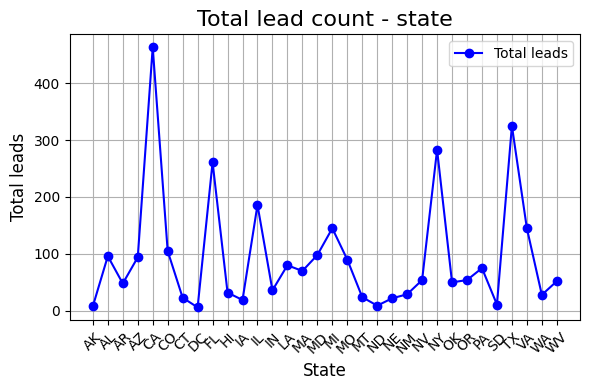

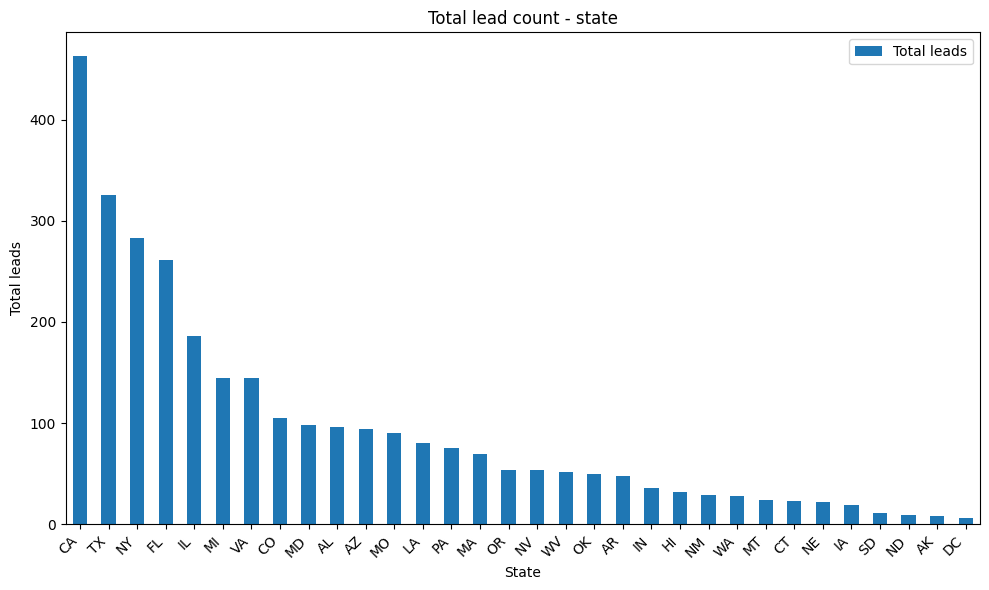

In [40]:
get_line_plot(statewise_breakdown_df, 'State', 'Total leads', 'Total lead count - state', marker='o', color='b')

get_histogram(statewise_breakdown_df, 'State', 'Total leads', 'Total lead count - state')

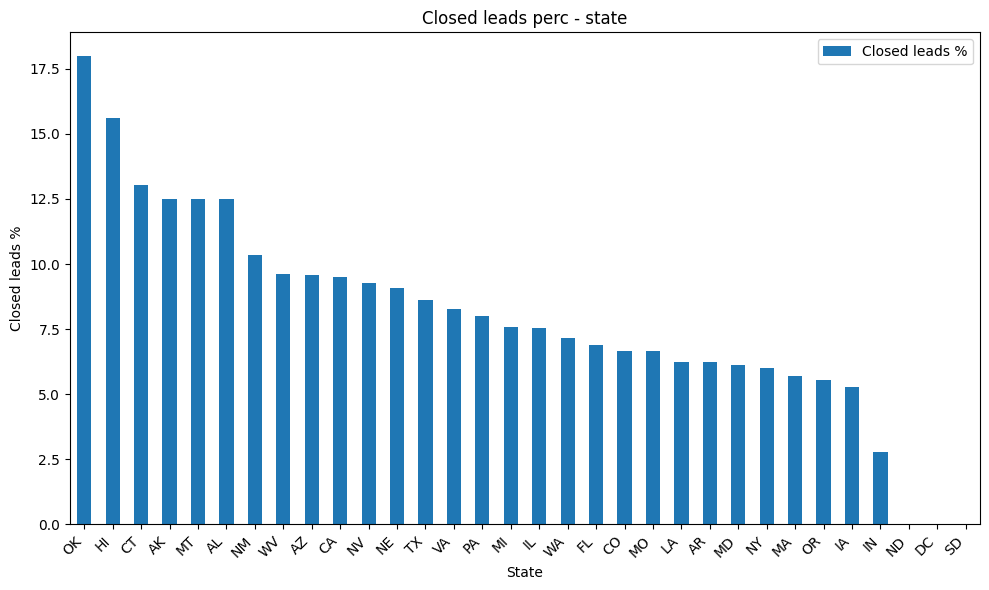

In [41]:



get_histogram(statewise_breakdown_df, 'State', 'Closed leads %', 'Closed leads perc - state')

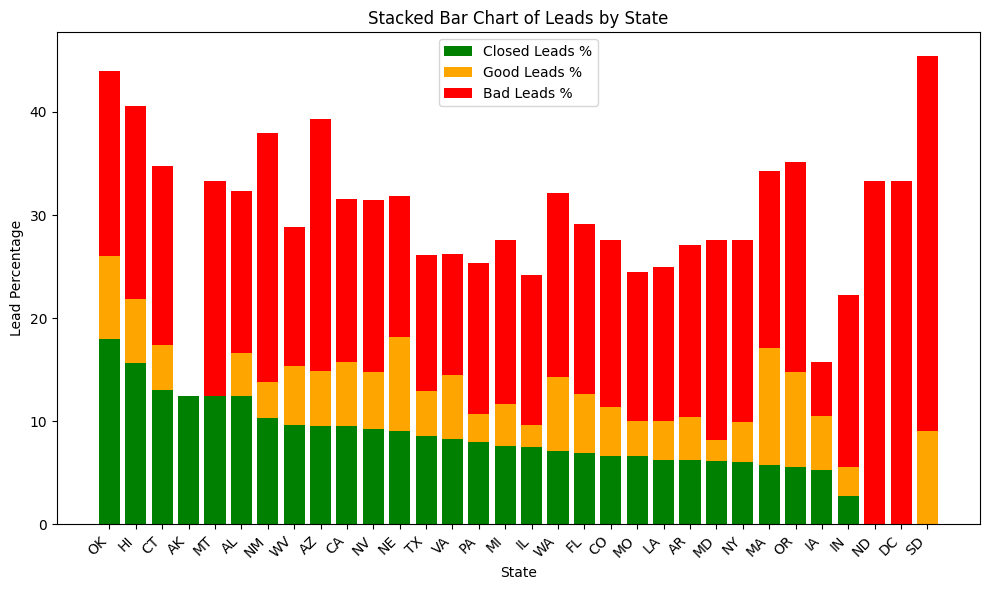

In [53]:
import matplotlib.pyplot as plt

def plot_stacked_bar_chart_with_total_percent(statewise_breakdown_df, closed_leads_col, good_leads_col, bad_leads_col, neutral_leads_col, title):
    # Sort the DataFrame by 'Closed leads %' in descending order based on the column value
    statewise_breakdown_df = statewise_breakdown_df.sort_values(by=closed_leads_col, ascending=False)
    
    # Calculate total leads per state (sum of all lead categories for each state)
    statewise_breakdown_df['Total Leads'] = statewise_breakdown_df[closed_leads_col] + statewise_breakdown_df[good_leads_col] + statewise_breakdown_df[bad_leads_col] + statewise_breakdown_df[neutral_leads_col]
    
    # Calculate the overall total leads across all states
    total_leads_all_states = statewise_breakdown_df['Total Leads'].sum()
    
    # Plot the stacked bar chart
    plt.figure(figsize=(10, 6))

    # Stacking the lead percentages for each state (index is 'State')
    plt.bar(statewise_breakdown_df.index, statewise_breakdown_df[closed_leads_col], label='Closed Leads %', color='green')
    plt.bar(statewise_breakdown_df.index, statewise_breakdown_df[good_leads_col], bottom=statewise_breakdown_df[closed_leads_col], label='Good Leads %', color='orange')
    plt.bar(statewise_breakdown_df.index, statewise_breakdown_df[bad_leads_col], bottom=statewise_breakdown_df[closed_leads_col] + statewise_breakdown_df[good_leads_col], label='Bad Leads %', color='red')
    #plt.bar(statewise_breakdown_df.index, statewise_breakdown_df[neutral_leads_col], bottom=statewise_breakdown_df[closed_leads_col] + statewise_breakdown_df[good_leads_col] + statewise_breakdown_df[bad_leads_col], label='Neutral Leads %', color='gray')

    # Adding labels and title
    plt.title(title)
    plt.xlabel('State')
    plt.ylabel('Lead Percentage')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add grid to the plot
    #plt.grid(True, axis='y')

    # Add legend to differentiate between lead categories
    plt.legend()

    # Add text annotations for total leads as a percentage of the overall total
    for i, state in enumerate(statewise_breakdown_df.index):
        # Get total leads for the state
        total_leads_state = statewise_breakdown_df['Total Leads'][state]
        
        # Calculate percentage of total leads for this state
        percent_of_total = (total_leads_state / total_leads_all_states) * 100
        
        # Add text annotation at the top of each bar (offset slightly for readability)
        #plt.text(i, statewise_breakdown_df['Total Leads'][state] + 2, f'{percent_of_total:.2f}', ha='center', va='bottom', fontsize=9)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function with your DataFrame and column names
plot_stacked_bar_chart_with_total_percent(statewise_breakdown_df, 'Closed leads %', 'Good leads %', 'Bad leads %', 'Neutral leads %', 'Stacked Bar Chart of Leads by State')


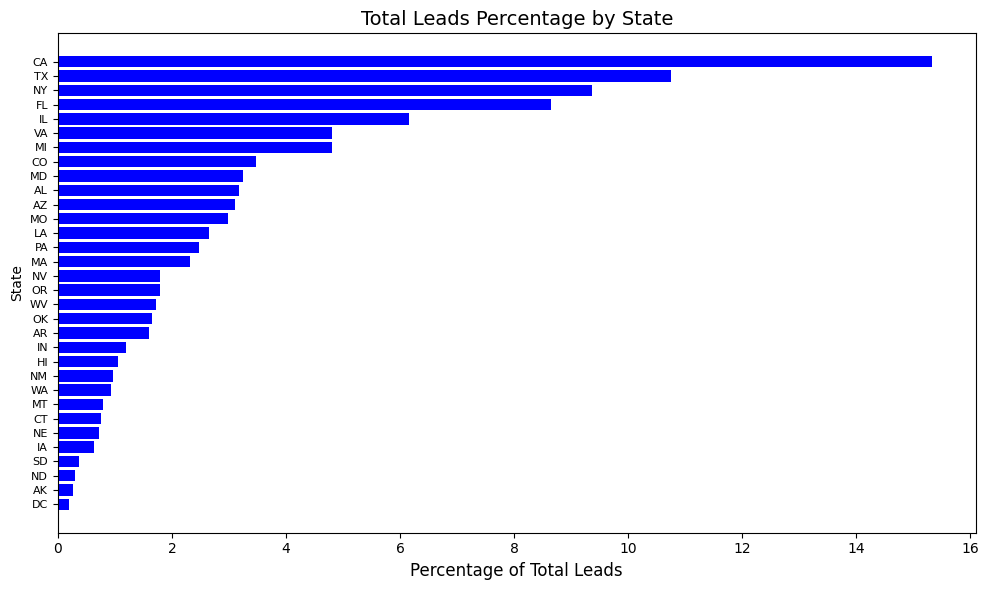

In [68]:
import matplotlib.pyplot as plt

def plot_horizontal_bar_with_percentage(df, state_col, total_leads_col, title):
    # Calculate the total leads across all states
    total_leads_all_states = df[total_leads_col].sum()

    # Calculate the percentage of total leads for each state
    df['Total Leads Percentage'] = (df[total_leads_col] / total_leads_all_states) * 100

    # Sort by 'Total Leads Percentage'
    df = df.sort_values('Total Leads Percentage', ascending=True)

    # Create a horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(df.index, df['Total Leads Percentage'], color='blue')

    # Add labels and title
    plt.title(title, fontsize=14)
    plt.xlabel('Percentage of Total Leads', fontsize=12)
    plt.ylabel('State', fontsize=10)

    # Adjust the font size of the state names on the y-axis
    plt.yticks(fontsize=8)

    # Add the percentage as text on the right of each bar
    #for i, value in enumerate(df['Total Leads Percentage']):
        #plt.text(value + 1, i, f'{value:.1f}', va='center', fontsize=8)

    # Add grid to the plot
    #plt.grid(True, axis='x')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function with your DataFrame and column names
plot_horizontal_bar_with_percentage(statewise_breakdown_df, 'State', 'Total leads', 'Total Leads Percentage by State')


In [102]:
df.columns

Index(['LeadCreated', 'FirstName', 'Email', 'VendorLeadID', 'CallStatus',
       'WidgetName', 'PublisherZoneName', 'PublisherCampaignName',
       'AddressScore', 'PhoneScore', 'AdvertiserCampaignName', 'State',
       'DebtLevel', 'IP Address', 'Partner', 'ReferralDomain',
       'MarketingCampaign', 'AdGroup', 'Keyword', 'SearchQuery', 'ReferralURL',
       'ReferralURL Parameters', 'LandingPageURL',
       'Landing Page URL Parameters', 'Date', 'Week', 'Month',
       'CallStatusEnum', 'AdSize', 'FieldSet', 'FormType', 'DesignName'],
      dtype='object')

## Debt Level ##

In [71]:
debtlevel_breakdown_df = get_quality_breakdown(df, 'DebtLevel')
debtlevel_breakdown_df


CallStatusEnum,Bad leads,Closed leads,Good leads,Neutral leads,Total leads,Closed leads %,Good leads %,Bad leads %,Neutral leads %,Weighted Quality Score
DebtLevel,,,,,,,,,,
10001-15000,49,34,20,188,291,11.683849,6.872852,16.838488,64.604811,0.553265
15001-20000,49,35,22,302,408,8.578431,5.392157,12.009804,74.019608,0.416667
20001-30000,70,40,32,314,456,8.771930,7.017544,15.350877,68.859649,0.425439
30001-50000,84,39,22,351,496,7.862903,4.435484,16.935484,70.766129,0.312500
50001-70000,34,22,16,173,245,8.979592,6.530612,13.877551,70.612245,0.440816
70001-90000,16,18,7,90,131,13.740458,5.343511,12.213740,68.702290,0.671756
7500-10000,109,22,9,302,442,4.977376,2.036199,24.660633,68.325792,0.042986
7500-15000,26,19,12,214,271,7.011070,4.428044,9.594096,78.966790,0.343173
90000-100000,13,9,2,66,90,10.000000,2.222222,14.444444,73.333333,0.400000


In [69]:
debtlevel_breakdown_df = get_quality_breakdown(df, 'DebtLevel')
debtlevel_breakdown_df


df['DebtLevel'].value_counts()

DebtLevel
30001-50000         496
20001-30000         456
7500-10000          442
15001-20000         408
10001-15000         291
7500-15000          271
50001-70000         245
More_than_100000    191
70001-90000         131
90000-100000         90
Name: count, dtype: int64

## Phone Score

In [77]:
nan_count = df['PhoneScore'].isna().sum()
nan_count

df['PhoneScore'].value_counts()

PhoneScore
5.0    619
3.0    427
4.0    184
2.0    162
1.0      1
Name: count, dtype: int64

In [85]:
df_phonescore = df.dropna(subset=['PhoneScore'])
phonescore_breakdown_df = get_quality_breakdown(df_phonescore , 'PhoneScore')
phonescore_breakdown_df

CallStatusEnum,Bad leads,Closed leads,Good leads,Neutral leads,Total leads,Closed leads %,Good leads %,Bad leads %,Neutral leads %,Weighted Quality Score
PhoneScore,,,,,,,,,,
1.0,1,0,0,0,1,0.000000,0.000000,100.000000,0.000000,-1.000000
2.0,33,7,9,113,162,4.320988,5.555556,20.370370,69.753086,0.123457
3.0,86,28,22,291,427,6.557377,5.152225,20.140515,68.149883,0.229508
4.0,31,7,6,140,184,3.804348,3.260870,16.847826,76.086957,0.086957
5.0,96,54,46,423,619,8.723748,7.431341,15.508885,68.336026,0.429725


## Address Score

In [76]:
addressScore_breakdown_df = get_quality_breakdown(df, 'AddressScore')
addressScore_breakdown_df

CallStatusEnum,Bad leads,Closed leads,Good leads,Neutral leads,Total leads,Closed leads %,Good leads %,Bad leads %,Neutral leads %,Weighted Quality Score
AddressScore,,,,,,,,,,
1.0,25,5,9,83,122,4.098361,7.377049,20.491803,68.032787,0.147541
2.0,7,4,3,24,38,10.526316,7.894737,18.421053,63.157895,0.500000
3.0,23,5,4,61,93,5.376344,4.301075,24.731183,65.591398,0.107527
4.0,11,1,1,35,48,2.083333,2.083333,22.916667,72.916667,-0.083333
5.0,136,64,56,614,870,7.356322,6.436782,15.632184,70.574713,0.340230


In [73]:
nan_count = df['AddressScore'].isna().sum()
nan_count

1850

In [89]:
Advertisercampaign_breakdown_df = get_quality_breakdown(df, 'AdvertiserCampaignName')
Advertisercampaign_breakdown_df

CallStatusEnum,Bad leads,Closed leads,Good leads,Neutral leads,Total leads,Closed leads %,Good leads %,Bad leads %,Neutral leads %,Weighted Quality Score
AdvertiserCampaignName,,,,,,,,,,
Debt Settlement1 Master,298,151,85,1281,1815,8.319559,4.683196,16.418733,70.578512,0.345455
creditsolutions-branded-shortform,190,94,63,859,1206,7.794362,5.223881,15.754561,71.227197,0.336650


In [90]:
df

,LeadCreated,FirstName,Email,VendorLeadID,CallStatus,WidgetName,PublisherZoneName,PublisherCampaignName,AddressScore,PhoneScore,...,LandingPageURL,Landing Page URL Parameters,Date,Week,Month,CallStatusEnum,AdSize,FieldSet,FormType,DesignName
0,7/1/09,Dorinda,kanani@sandwichisles.net,FDF81FDA-A649-437B-B99C-FDDE74F7971B,NaN,w-302252-DebtReduction1-1DC-CreditSolutions,TopLeft-302252,DebtReductionInc,NaN,5.0,...,http://www.debtreductioninc.com/index8.html,utm_source=google&utm_medium=CPC&utm_content=H...,2009-07-01,27,7,Neutral leads,302x252,DebtReduction1,1DC,CreditSolutions
1,4/13/09,Presetta,clerk2@ustconline.net,4190ACB7-5026-416C-B987-ED8AD427D5E6,NaN,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...,2009-04-13,16,4,Neutral leads,300x250,DebtReduction1,1DC,Head2
2,4/21/09,Gina,wagoner_gina@yahoo.com,hFg80jf_R0CRN55hdhWILw,Unable to contact - Bad Contact Information,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...,2009-04-21,17,4,Bad leads,300x250,DebtReduction1,1DC,Head2
3,8/3/09,Kari,usa4ley@yahoo.com,jB01QgYZxkWArI9jWxuufw,Contacted - Doesn't Qualify,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,5.0,3.0,...,http://www.debtreductioninc.com/index12.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,2009-08-03,32,8,Bad leads,302x252,DebtReduction1,1DC,white
4,4/13/09,Stephanie,sr1lambert@embarqmail.com,D5B32074-458E-40EC-B185-1FEF20AC626D,NaN,w-300250-DebtReduction1-1DC-BlueMeter,TopLeft-302252,DebtReductionInc,NaN,NaN,...,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,2009-04-13,16,4,Neutral leads,300x250,DebtReduction1,1DC,BlueMeter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,6/30/09,amy,ahokett@sjc.edu,F42BBDFB-D44B-4890-A1B6-D1F0A3838214,NaN,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,NaN,NaN,...,http://www.debtreductioninc.com/index8.html,utm_source=yahoo&utm_medium=cpc&utm_campaign=D...,2009-06-30,27,6,Neutral leads,302x252,DebtReduction1,1DC,white
3017,4/25/09,brandy,brandy75137@yahoo.com,EA3703A3-61C9-40CE-92F7-61F0E02B1365,NaN,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,2009-04-25,17,4,Neutral leads,300x250,DebtReduction1,1DC,Head2
3018,4/12/09,jennifer,jennifer_woods48375@yahoo.com,64EB2632-E29E-4EB4-B361-45F1F0C735B5,NaN,w-300250-DebtReduction1-1DC-CreditSolutions,TopLeft-302252,DebtReductionInc,NaN,NaN,...,http://www.debtreductioninc.com/index8.html,utm_source=yahoo&utm_medium=cpc&utm_campaign=D...,2009-04-12,15,4,Neutral leads,300x250,DebtReduction1,1DC,CreditSolutions
3019,9/23/09,debra,debraroque@att.net,9126C7DB-F5BB-4CE1-BDCF-5E6F1841ADAD,NaN,w-302252-DebtReduction1-1DC-yellowarrow-dark,TopLeft-302252,DebtReductionInc,5.0,5.0,...,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,2009-09-23,39,9,Neutral leads,302x252,DebtReduction1,1DC,yellowarrow-dark


## Widgets 

In [92]:
formtype_breakdown_df = get_quality_breakdown(df, 'FormType')
formtype_breakdown_df

CallStatusEnum,Bad leads,Closed leads,Good leads,Neutral leads,Total leads,Closed leads %,Good leads %,Bad leads %,Neutral leads %,Weighted Quality Score
FormType,,,,,,,,,,
1DC,467,233,140,2019,2859,8.149703,4.896817,16.334383,70.619098,0.342078
2DC,21,12,8,121,162,7.407407,4.938272,12.962963,74.691358,0.339506


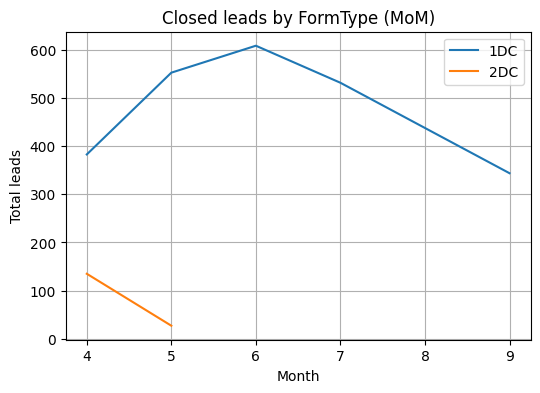

In [101]:
get_multi_line_plot(df, 'Month', 'Total leads', 'FormType', 'Total leads by FormType (MoM)')

In [106]:
widget_breakdown_df_2 = get_quality_breakdown(df, 'DesignName').sort_values(by='Total leads', ascending=False)
widget_breakdown_df_2

CallStatusEnum,Bad leads,Closed leads,Good leads,Neutral leads,Total leads,Closed leads %,Good leads %,Bad leads %,Neutral leads %,Weighted Quality Score
DesignName,,,,,,,,,,
1DC-CreditSolutions,178,88,61,804,1131,7.780725,5.393457,15.738285,71.087533,0.339523
1DC,118,57,31,414,620,9.193548,5.000000,19.032258,66.774194,0.369355
1DC-white,69,32,13,322,436,7.339450,2.981651,15.825688,73.853211,0.268349
1DC-yellowarrow-blue,49,15,16,152,232,6.465517,6.896552,21.120690,65.517241,0.250000
1DC-yellowarrow-dark,25,10,5,95,135,7.407407,3.703704,18.518519,70.370370,0.259259
1DC-BlueMeter,4,13,1,74,92,14.130435,1.086957,4.347826,80.434783,0.684783
1DC-Head2,8,11,3,67,89,12.359551,3.370787,8.988764,75.280899,0.595506
2DC-BlueMeter,9,6,6,66,87,6.896552,6.896552,10.344828,75.862069,0.379310
1DC-Head3,7,4,1,63,75,5.333333,1.333333,9.333333,84.000000,0.200000


## Ad Partners

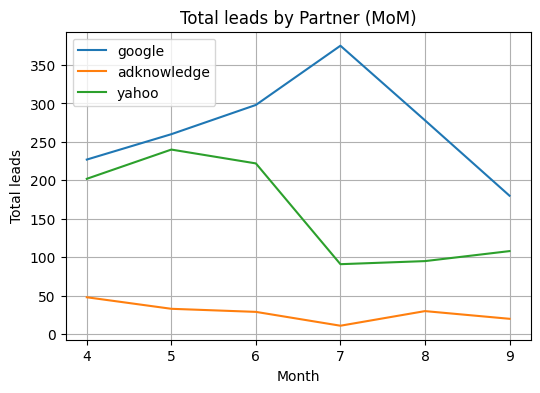

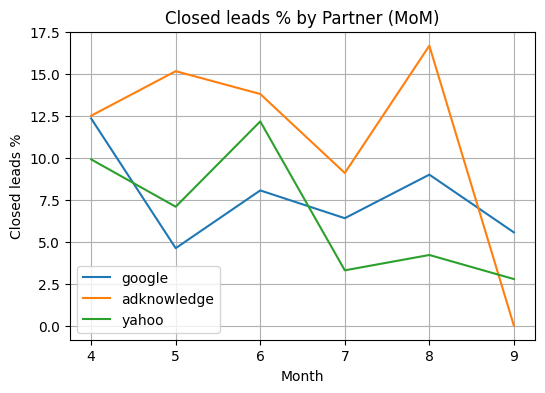

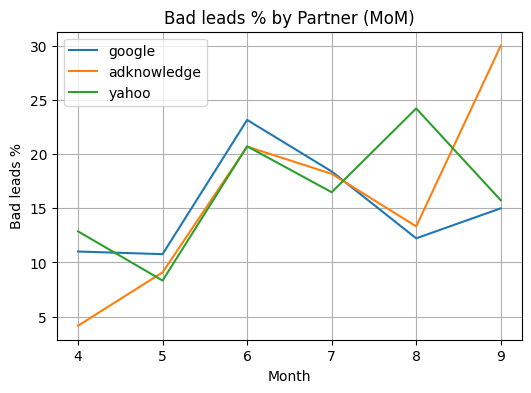

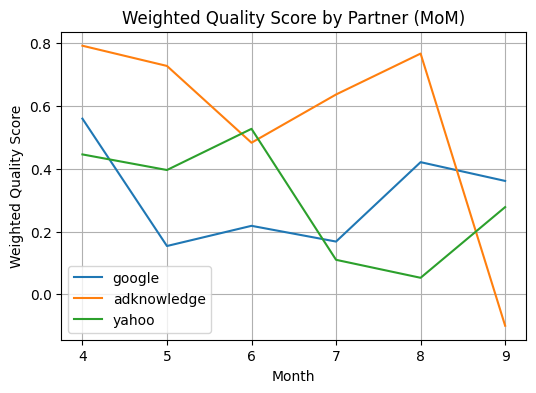

CallStatusEnum,Bad leads,Closed leads,Good leads,Neutral leads,Total leads,Closed leads %,Good leads %,Bad leads %,Neutral leads %,Weighted Quality Score
Partner,,,,,,,,,,
adknowledge,23,21,11,116,171,12.280702,6.432749,13.450292,67.836257,0.608187
google,252,123,57,1186,1618,7.601978,3.522868,15.574784,73.300371,0.294808
yahoo,147,74,62,675,958,7.724426,6.471816,15.344468,70.459290,0.362213


In [118]:
# def get_multi_line_plot(df, x, y, label, title, ):
#     plt.figure(figsize=(6, 4))
#     for i in filtered_df[label].unique():
#       i_data = filtered_df[filtered_df[label] == i]
#       i_breakdown = get_quality_breakdown(i_data, x)
#       plt.plot(i_breakdown.index, i_breakdown[y], label=i)
#     plt.xlabel(x)
#     plt.ylabel(y)
#     plt.title(title)
#     plt.legend()
#     plt.grid(True)
#     plt.show()


filtered_df = df[df['Partner'].isin(['google', 'yahoo', 'adknowledge'])]


# Month over Month analysis on graph
get_multi_line_plot(filtered_df, 'Month', 'Total leads', 'Partner', 'Total leads by Partner (MoM)')
get_multi_line_plot(filtered_df, 'Month', 'Closed leads %', 'Partner', 'Closed leads % by Partner (MoM)')
get_multi_line_plot(filtered_df, 'Month', 'Bad leads %', 'Partner', 'Bad leads % by Partner (MoM)')
get_multi_line_plot(filtered_df, 'Month', 'Weighted Quality Score', 'Partner', 'Weighted Quality Score by Partner (MoM)')

# Aggregate Analysis
breakdown_df = get_quality_breakdown(filtered_df, 'Partner')
breakdown_df

## Landing Page URL

In [119]:
lp_grouped_data = df.groupby(['LandingPageURL', 'Partner']).size().reset_index(name='counts')
lp_sorted_data = lp_grouped_data.sort_values('counts', ascending=False).head(15)
lp_sorted_data

,LandingPageURL,Partner,counts
4,http://www.debtreductioninc.com/index8.html,google,1408
5,http://www.debtreductioninc.com/index8.html,yahoo,958
7,https://callcenter.inadcoads.com/callcenter/si...,call_center,188
2,http://www.debtreductioninc.com/index8.html,adknowledge,171
1,http://www.debtreductioninc.com/index12.html,google,124
0,http://www.debtreductioninc.com/index11.html,google,86
6,http://www.inadcoad.com/callcenter/signius/cal...,call_center,83
3,http://www.debtreductioninc.com/index8.html,advertise.com,3


In [120]:
landing_page_breakdown = get_quality_breakdown(df, 'LandingPageURL').sort_values(by='Total leads', ascending=False).head(10)
landing_page_breakdown

CallStatusEnum,Bad leads,Closed leads,Good leads,Neutral leads,Total leads,Closed leads %,Good leads %,Bad leads %,Neutral leads %,Weighted Quality Score
LandingPageURL,,,,,,,,,,
http://www.debtreductioninc.com/index8.html,378,211,127,1824,2540,8.307087,5.000000,14.881890,71.811024,0.366535
https://callcenter.inadcoads.com/callcenter/signius/callcenterdri.html,57,22,12,97,188,11.702128,6.382979,30.319149,51.595745,0.409574
http://www.debtreductioninc.com/index12.html,28,2,2,92,124,1.612903,1.612903,22.580645,74.193548,-0.112903
http://www.debtreductioninc.com/index11.html,16,6,1,63,86,6.976744,1.162791,18.604651,73.255814,0.186047
http://www.inadcoad.com/callcenter/signius/callcenterdri.html,9,4,6,64,83,4.819277,7.228916,10.843373,77.108434,0.277108


## Keywords


In [124]:
key_word_breakdown = get_quality_breakdown(df, 'Keyword').sort_values(by='Total leads', ascending=False).head(10)
key_word_breakdown

CallStatusEnum,Bad leads,Closed leads,Good leads,Neutral leads,Total leads,Closed leads %,Good leads %,Bad leads %,Neutral leads %,Weighted Quality Score
Keyword,,,,,,,,,,
debt,20,14,12,111,157,8.917197,7.643312,12.738854,70.700637,0.471338
credit card payments,20,7,3,74,104,6.730769,2.884615,19.230769,71.153846,0.201923
student loan default,12,0,1,38,51,0.000000,1.960784,23.529412,74.509804,-0.196078
loan default help,19,0,0,25,44,0.000000,0.000000,43.181818,56.818182,-0.431818
credit services,5,2,0,14,21,9.523810,0.000000,23.809524,66.666667,0.238095
debt cures,7,1,0,13,21,4.761905,0.000000,33.333333,61.904762,-0.095238
consumer debt initiative,3,5,1,11,20,25.000000,5.000000,15.000000,55.000000,1.200000
credit counselor,1,0,2,15,18,0.000000,11.111111,5.555556,83.333333,0.166667
debt rescue usa,1,3,2,10,16,18.750000,12.500000,6.250000,62.500000,1.125000
